# CLS Embedding

In [4]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
# from catboost import CatBoostClassifier
import pickle
from joblib import dump, load
# from interpretation_code import interpretation
# from k_fold_cv import k_fold
import random
import numpy as np
import torch as tt

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from joblib import dump


class model_trainer:

    def __init__(self, train_path, test_path, model_name):
        self.train_df=self.load_dataset(train_path)
        self.test_df=self.load_dataset(test_path)
        self.model_name=self.load_model(model_name)
        self.tokenizer=self.load_tokenizer(model_name)
#         self.model_name.resize_token_embeddings(len(self.tokenizer))
        

    def load_model(self,model_name):
        print("model_name")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        biobert = BertModel.from_pretrained(model_name).to(self.device)
#         biobert = BertModel.from_pretrained("biobert_model_initial").to(self.device)
        biobert = biobert.eval()
        print("BioBERT model loaded")
#         biobert.save_pretrained("biobert_model_initial")

        return biobert

    def load_tokenizer(self,model_name):
        tokenizer = BertTokenizer.from_pretrained(model_name)
#         tokenizer.add_tokens(["GeneSrc", "DiseaseTgt", "causative", "causal", "cause", "causing", "caused"])
#         tokenizer.save_pretrained("biobert_tokenizer")

#         tokenizer = BertTokenizer.from_pretrained("biobert_tokenizer")
        
        print("Tokenizer loaded")
        return tokenizer

    def load_dataset(self,data_path):
        df = pd.read_csv(data_path, delimiter='\t')
#         df.drop_duplicates(inplace=True)
#         df = df.dropna()
        return df
    
    def remove_stopwords(self,text):
        #nltk.download('stopwords')
        stop_words = set(stopwords.words('english'))
        
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word.lower() not in stop_words]
        return ' '.join(tokens)
    
    
    def create_dataset(self):
        # Apply the remove_stopwords function to the 'sentence' column
        self.train_df['sentence'] = self.train_df['sentence'].apply(self.remove_stopwords)
        self.test_df['sentence'] = self.test_df['sentence'].apply(self.remove_stopwords)

        X_train = self.train_df['sentence'].tolist()
        y_train = self.train_df['label'].tolist()

        X_test = self.test_df['sentence'].tolist()
        y_test = self.test_df['label'].tolist()
        
        print("Dataset created")
        
        return X_train,y_train,X_test,y_test
    
    def get_specific_token_embeddings(self,sentence):
        # 1. Tokenize the input sentence
        inputs = self.tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512).to(self.device)

        # 2. Find the indices of "@GeneSrc" and "@DiseaseTgt$"
        tokenized_sentence = self.tokenizer.tokenize(sentence)
        gene_src_token = self.tokenizer.tokenize("@GeneSrc$")
        disease_tgt_token = self.tokenizer.tokenize("@DiseaseTgt$")

        gene_src_indices = [i for i, token in enumerate(tokenized_sentence) if token in gene_src_token]
        disease_tgt_indices = [i for i, token in enumerate(tokenized_sentence) if token in disease_tgt_token]

        # Run the sentence through BioBERT
        with torch.no_grad():
            #print(self.model_name)
            outputs = self.model_name(**inputs)
            embeddings = outputs['last_hidden_state'][:,0, :]  # Extracting embeddings for the whole sentence
        return embeddings.cpu().numpy()
            
        # 3. Retrieve the embeddings for the surrounding tokens
#         context_range = 2

#         def get_context_embeddings(indices):
#             context_embeddings = []
#             for idx in indices:
#                 start = max(0, idx - context_range)
#                 end = min(idx + context_range + 1, len(tokenized_sentence))
#                 context = embeddings[start:end]
#                 context_embeddings.append(context)
#             return torch.cat(context_embeddings).view(-1, 768)

#         gene_src_embeddings = get_context_embeddings(gene_src_indices)
#         disease_tgt_embeddings = get_context_embeddings(disease_tgt_indices)

#         # 4. Compute the average of the embeddings
#         avg_gene_src_embedding = torch.mean(gene_src_embeddings, dim=0)
#         avg_disease_tgt_embedding = torch.mean(disease_tgt_embeddings, dim=0)

#         combined_embedding = torch.cat([avg_gene_src_embedding, avg_disease_tgt_embedding], dim=0)
#         combined_embedding_np = combined_embedding.cpu().numpy().reshape(1, -1)  # Convert tensor to NumPy array and reshape to 2D

#         if np.isnan(combined_embedding_np).any():
#             print(sentence)

#         return combined_embedding_np

        
        
    def generate_embeddings(self):
        X_train,y_train,X_test,y_test=self.create_dataset()
        try:
            X_train_embeddings = np.vstack([self.get_specific_token_embeddings(sentence) for sentence in tqdm(X_train)])
            X_test_embeddings = np.vstack([self.get_specific_token_embeddings(sentence) for sentence in tqdm(X_test)])
           
        except Exception as e:
            print(e)
            pass
        print("Embeddings generated")
        return X_train_embeddings,X_test_embeddings
    
    def drop_null_embeddings(self,X_train_embeddings,X_test_embeddings,y_train,y_test):
        X_train_embeddings=pd.DataFrame(X_train_embeddings).dropna()
        X_test_embeddings=pd.DataFrame(X_test_embeddings).dropna()

        test_ind=[i for i in range(0,len(X_test_embeddings)) if i not in X_test_embeddings.index]
        train_ind=[i for i in range(0,len(X_train_embeddings)) if i not in X_train_embeddings.index]
        for i in train_ind:
            y_train.pop(i)
        for i in test_ind:
            y_test.pop(i)
            
        return X_train_embeddings,X_test_embeddings,y_train,y_test
    


    def svm_classification(self, X_train_embeddings,y_train,X_test_embeddings,y_test,X_test):
        print("Doing classification using SVM...")
        clf = SVC(kernel='poly', degree=30, probability=True, class_weight={0:1, 1:30}, C=10)
        clf.fit(X_train_embeddings, y_train)
#         dump(clf, 'svm_model.joblib')
#         print('model saved')

        # Predict and Evaluate
        y_pred = clf.predict(X_test_embeddings)
        print("Results of SVM classifier are: ")
        print(classification_report(y_test, y_pred))
        probas = clf.predict_proba(X_test_embeddings)[:, 1]  # Get probabilities for the positive class
        return probas


    def xg_boost_classification(self, X_train_embeddings,y_train,X_test_embeddings,y_test):
        print("Doing classification using XG Boost...")
        
        clf = xgb.XGBClassifier(scale_pos_weight=200, max_depth=40, learning_rate=0.2, n_estimators=100, gamma=0.3)
        clf.fit(X_train_embeddings, y_train)

        # Get probabilities
        y_prob = clf.predict_proba(X_test_embeddings)

        # Predict and Evaluate
        y_pred = clf.predict(X_test_embeddings)
        
        # Save the model to a file
        dump(clf, 'xgb_model.joblib') 

        print("Results of XG Boost are: ")
        print(classification_report(y_test, y_pred))
        
    def random_forest(self, X_train_embeddings,y_train,X_test_embeddings,y_test):
        print("Doing classification using Random Forest...")
        

        # Instantiate the Random Forest Classifier
        clf = RandomForestClassifier(n_estimators=100, max_depth=10, max_leaf_nodes= 500, n_jobs= 2, max_features="sqrt", class_weight={0:1, 1:30}, verbose=True)
        clf.fit(X_train_embeddings, y_train)

        # Predict and Evaluate
        y_pred = clf.predict(X_test_embeddings)
        print("Results of Random Forest are: ")
        print(classification_report(y_test, y_pred))
        

        
    def interpretation_call(self):

        causal_test_df=self.test_df[self.test_df["label"]==1]
        causal_df_unique = causal_test_df.drop_duplicates(subset=['index', 'id1', 'id2'])

        samp_abst=causal_df_unique[causal_df_unique["index"]==25064704]

        # Load the model from a file
        clf = load('CRED_trained_model.joblib')

#         model_name = "Dinithi/ClinicalTextV4"

        model_name = "dmis-lab/biobert-base-cased-v1.1"
        biobert = BertModel.from_pretrained(model_name).to(self.device)
        tokenizer = BertTokenizer.from_pretrained(model_name)

        for _, row in tqdm(causal_df_unique.iterrows()):
            ranked, word_importance = interpretation(row, clf, tokenizer, biobert, self.get_specific_token_embeddings)

    def generate_embeddings_new(self, new_data):
        new_data=self.create_dataset_new(new_data)
        try:
            X_new_embeddings = np.vstack([self.get_specific_token_embeddings(sentence) for sentence in tqdm(new_data)])
        except Exception as e:
            print(e)
            return None
        print("Embeddings generated for new data")
        return X_new_embeddings

    def drop_null_embeddings_new(self,X_new_embeddings):
        X_new_embeddings=pd.DataFrame(X_new_embeddings).dropna()

        test_ind=[i for i in range(0,len(X_new_embeddings)) if i not in X_new_embeddings.index]            
        return X_new_embeddings
    
    def create_dataset_new(self, new_data):
        new_data['sentence'] = new_data['sentence'].apply(self.remove_stopwords)
        new_data = new_data['sentence'].tolist()
        return new_data

    
# def main():       
mod_tr = model_trainer('new_train_data', 'test_data', "dmis-lab/biobert-base-cased-v1.1")
# X_train_embeddings,X_test_embeddings= mod_tr.generate_embeddings()
X_train, y_train, X_test, y_test = mod_tr.create_dataset()

# Reading the training embeddings from the text file
# X_train_embeddings = pd.read_csv('X_train_embeddings.txt', sep='\t', header=None)
# X_test_embeddings = pd.read_csv('X_test_embeddings.txt', sep='\t', header=None)
# X_train_embeddings, X_test_embeddings, y_train, y_test = mod_tr.drop_null_embeddings(X_train_embeddings, X_test_embeddings, y_train, y_test)
print("Embeddings generated")

# # SVM Classification
# mod_tr.svm_classification(X_train_embeddings, y_train, X_test_embeddings, y_test)
# # XGBoost Classification
# mod_tr.xg_boost_classification(X_train_embeddings, y_train, X_test_embeddings, y_test)



model_name
BioBERT model loaded
Tokenizer loaded
Dataset created
Embeddings generated


In [5]:
# # Saving the training embeddings to a text file
# pd.DataFrame(X_train_embeddings).to_csv('X_train_embeddings_cls.txt', sep='\t', index=False, header=False)

# # Saving the test embeddings to a text file
# pd.DataFrame(X_test_embeddings).to_csv('X_test_embeddings_cls.txt', sep='\t', index=False, header=False)


In [6]:
# Reading the training embeddings from the text file
X_train_embeddings = pd.read_csv('X_train_embeddings_cls.txt', sep='\t', header=None)

# Reading the test embeddings from the text file
X_test_embeddings = pd.read_csv('X_test_embeddings_cls.txt', sep='\t', header=None)

In [7]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


# SVM Classification
svm_probs_cls = mod_tr.svm_classification(X_train_embeddings, y_train, X_test_embeddings, y_test,X_test)
precision_svm_cls, recall_svm_cls, _ = precision_recall_curve(y_test, svm_probs_cls)


Doing classification using SVM...
Results of SVM classifier are: 
              precision    recall  f1-score   support

           0       0.94      0.89      0.92       561
           1       0.27      0.41      0.32        54

    accuracy                           0.85       615
   macro avg       0.60      0.65      0.62       615
weighted avg       0.88      0.85      0.86       615



# combining cls and g-d embeddings


In [8]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
# from catboost import CatBoostClassifier
import pickle
from joblib import dump, load
# from interpretation_code import interpretation
# from k_fold_cv import k_fold
import random
import numpy as np
import torch as tt

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from joblib import dump


class model_trainer:

    def __init__(self, train_path, test_path, model_name):
        self.train_df=self.load_dataset(train_path)
        self.test_df=self.load_dataset(test_path)
        self.model_name=self.load_model(model_name)
        self.tokenizer=self.load_tokenizer(model_name)
#         self.model_name.resize_token_embeddings(len(self.tokenizer))
        

    def load_model(self,model_name):
        print("model_name")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        biobert = BertModel.from_pretrained(model_name).to(self.device)
#         biobert = BertModel.from_pretrained("biobert_model_initial").to(self.device)
        biobert = biobert.eval()
        print("BioBERT model loaded")
#         biobert.save_pretrained("biobert_model_initial")

        return biobert

    def load_tokenizer(self,model_name):
        tokenizer = BertTokenizer.from_pretrained(model_name)
#         tokenizer.add_tokens(["GeneSrc", "DiseaseTgt", "causative", "causal", "cause", "causing", "caused"])
#         tokenizer.save_pretrained("biobert_tokenizer")

#         tokenizer = BertTokenizer.from_pretrained("biobert_tokenizer")
        
        print("Tokenizer loaded")
        return tokenizer

    def load_dataset(self,data_path):
        df = pd.read_csv(data_path, delimiter='\t')
#         df.drop_duplicates(inplace=True)
#         df = df.dropna()
        return df
    
    def remove_stopwords(self,text):
        #nltk.download('stopwords')
        stop_words = set(stopwords.words('english'))
        
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word.lower() not in stop_words]
        return ' '.join(tokens)
    
    
    def create_dataset(self):
        # Apply the remove_stopwords function to the 'sentence' column
        self.train_df['sentence'] = self.train_df['sentence'].apply(self.remove_stopwords)
        self.test_df['sentence'] = self.test_df['sentence'].apply(self.remove_stopwords)

        X_train = self.train_df['sentence'].tolist()
        y_train = self.train_df['label'].tolist()

        X_test = self.test_df['sentence'].tolist()
        y_test = self.test_df['label'].tolist()
        
        print("Dataset created")
        
        return X_train,y_train,X_test,y_test
    
    def get_specific_token_embeddings(self, sentence):
    # 1. Tokenize the input sentence
        inputs = self.tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512).to(self.device)

        # 2. Find the indices of "@GeneSrc$" and "@DiseaseTgt$"
        tokenized_sentence = self.tokenizer.tokenize(sentence)
        gene_src_token = self.tokenizer.tokenize("@GeneSrc$")
        disease_tgt_token = self.tokenizer.tokenize("@DiseaseTgt$")

        gene_src_indices = [i for i, token in enumerate(tokenized_sentence) if token in gene_src_token]
        disease_tgt_indices = [i for i, token in enumerate(tokenized_sentence) if token in disease_tgt_token]

        # Run the sentence through BioBERT
        with torch.no_grad():
            outputs = self.model_name(**inputs)
            embeddings = outputs['last_hidden_state']  # Get embeddings for all tokens

        # 3. Retrieve the embeddings for the surrounding tokens
        context_range = 2

        def get_context_embeddings(indices):
            context_embeddings = []
            for idx in indices:
                start = max(0, idx - context_range)
                end = min(idx + context_range + 1, len(tokenized_sentence))
                context = embeddings[:, start:end, :]  # Slicing to get the relevant token embeddings
                context_embeddings.append(context)
            return torch.cat(context_embeddings, dim=1)  # Concatenate along sequence dimension

        gene_src_embeddings = get_context_embeddings(gene_src_indices)
        disease_tgt_embeddings = get_context_embeddings(disease_tgt_indices)

        # 4. Compute the average of the embeddings
        avg_gene_src_embedding = torch.mean(gene_src_embeddings, dim=1)
        avg_disease_tgt_embedding = torch.mean(disease_tgt_embeddings, dim=1)

        # 5. Extract the CLS embedding
        cls_embedding = embeddings[:, 0, :]  # First token of each sequence is the CLS token

        # 6. Combine the embeddings
        combined_embedding = torch.cat([cls_embedding, avg_gene_src_embedding, avg_disease_tgt_embedding], dim=1)
        combined_embedding_np = combined_embedding.cpu().numpy().reshape(1, -1)  # Convert tensor to NumPy array and reshape to 2D

        if np.isnan(combined_embedding_np).any():
            print(sentence)

        return combined_embedding_np

        
        
    def generate_embeddings(self):
        X_train,y_train,X_test,y_test=self.create_dataset()
        try:
            X_train_embeddings = np.vstack([self.get_specific_token_embeddings(sentence) for sentence in tqdm(X_train)])
            X_test_embeddings = np.vstack([self.get_specific_token_embeddings(sentence) for sentence in tqdm(X_test)])
           
        except Exception as e:
            print(e)
            pass
        print("Embeddings generated")
        return X_train_embeddings,X_test_embeddings
    
    def drop_null_embeddings(self,X_train_embeddings,X_test_embeddings,y_train,y_test):
        X_train_embeddings=pd.DataFrame(X_train_embeddings).dropna()
        X_test_embeddings=pd.DataFrame(X_test_embeddings).dropna()

        test_ind=[i for i in range(0,len(X_test_embeddings)) if i not in X_test_embeddings.index]
        train_ind=[i for i in range(0,len(X_train_embeddings)) if i not in X_train_embeddings.index]
        for i in train_ind:
            y_train.pop(i)
        for i in test_ind:
            y_test.pop(i)
            
        return X_train_embeddings,X_test_embeddings,y_train,y_test
    
    def svm_classification(self, X_train_embeddings,y_train,X_test_embeddings,y_test,X_test):
        print("Doing classification using SVM...")
        clf = SVC(kernel='poly', degree=10, probability=True, class_weight={0:1, 1:30}, C=1)
        clf.fit(X_train_embeddings, y_train)
#         dump(clf, 'svm_model.joblib')
#         print('model saved')

        # Predict and Evaluate
        y_pred = clf.predict(X_test_embeddings)
        print("Results of SVM classifier are: ")
        print(classification_report(y_test, y_pred))
        probas = clf.predict_proba(X_test_embeddings)[:, 1]  # Get probabilities for the positive class
        return probas


    def xg_boost_classification(self, X_train_embeddings,y_train,X_test_embeddings,y_test):
        print("Doing classification using XG Boost...")
        
        clf = xgb.XGBClassifier(scale_pos_weight=200, max_depth=20, learning_rate=0.2, n_estimators=100, gamma=0.1)
        clf.fit(X_train_embeddings, y_train)

        # Get probabilities
        y_prob = clf.predict_proba(X_test_embeddings)

        # Predict and Evaluate
        y_pred = clf.predict(X_test_embeddings)
        
        # Save the model to a file
        dump(clf, 'xgb_model.joblib') 

        print("Results of XG Boost are: ")
        print(classification_report(y_test, y_pred))
        
    def random_forest(self, X_train_embeddings,y_train,X_test_embeddings,y_test):
        print("Doing classification using Random Forest...")
        

        # Instantiate the Random Forest Classifier
        clf = RandomForestClassifier(n_estimators=100, max_depth=10, max_leaf_nodes= 500, n_jobs= 2, max_features="sqrt", class_weight={0:1, 1:30}, verbose=True)
        clf.fit(X_train_embeddings, y_train)

        # Predict and Evaluate
        y_pred = clf.predict(X_test_embeddings)
        print("Results of Random Forest are: ")
        print(classification_report(y_test, y_pred))
        
    def cat_boost(self, X_train_embeddings,y_train,X_test_embeddings,y_test):
        print("Doing classification using Cat Boost...")
        
        clf = CatBoostClassifier(iterations=500, 
                         depth=10, 
                         learning_rate=0.1, 
                         custom_loss='Logloss',
                         verbose=200,
                         class_weights=[1, 30])

        clf.fit(X_train_embeddings, y_train)

        # Predict and Evaluate
        y_pred = clf.predict(X_test_embeddings)
        print("Results of Cat Boost classifier are: ")
        print(classification_report(y_test, y_pred))
        
    def interpretation_call(self):

        causal_test_df=self.test_df[self.test_df["label"]==1]
        causal_df_unique = causal_test_df.drop_duplicates(subset=['index', 'id1', 'id2'])

        samp_abst=causal_df_unique[causal_df_unique["index"]==25064704]

        # Load the model from a file
        clf = load('CRED_trained_model.joblib')

#         model_name = "Dinithi/ClinicalTextV4"

        model_name = "dmis-lab/biobert-base-cased-v1.1"
        biobert = BertModel.from_pretrained(model_name).to(self.device)
        tokenizer = BertTokenizer.from_pretrained(model_name)

        for _, row in tqdm(causal_df_unique.iterrows()):
            ranked, word_importance = interpretation(row, clf, tokenizer, biobert, self.get_specific_token_embeddings)

    def generate_embeddings_new(self, new_data):
        new_data=self.create_dataset_new(new_data)
        try:
            X_new_embeddings = np.vstack([self.get_specific_token_embeddings(sentence) for sentence in tqdm(new_data)])
        except Exception as e:
            print(e)
            return None
        print("Embeddings generated for new data")
        return X_new_embeddings

    def drop_null_embeddings_new(self,X_new_embeddings):
        X_new_embeddings=pd.DataFrame(X_new_embeddings).dropna()

        test_ind=[i for i in range(0,len(X_new_embeddings)) if i not in X_new_embeddings.index]            
        return X_new_embeddings
    
    def create_dataset_new(self, new_data):
        new_data['sentence'] = new_data['sentence'].apply(self.remove_stopwords)
        new_data = new_data['sentence'].tolist()
        return new_data

    
# def main():       
mod_tr = model_trainer('new_train_data', 'test_data', "dmis-lab/biobert-base-cased-v1.1")
# X_train_embeddings,X_test_embeddings= mod_tr.generate_embeddings()
X_train, y_train, X_test, y_test = mod_tr.create_dataset()

# Reading the training embeddings from the text file
# X_train_embeddings = pd.read_csv('X_train_embeddings.txt', sep='\t', header=None)
# X_test_embeddings = pd.read_csv('X_test_embeddings.txt', sep='\t', header=None)
# X_train_embeddings, X_test_embeddings, y_train, y_test = mod_tr.drop_null_embeddings(X_train_embeddings, X_test_embeddings, y_train, y_test)
print("Embeddings generated")

# SVM Classification
# mod_tr.svm_classification(X_train_embeddings, y_train, X_test_embeddings, y_test)
# XGBoost Classification
# mod_tr.xg_boost_classification(X_train_embeddings, y_train, X_test_embeddings, y_test)



model_name
BioBERT model loaded
Tokenizer loaded
Dataset created
Embeddings generated


In [9]:
# # Saving the training embeddings to a text file
# pd.DataFrame(X_train_embeddings).to_csv('X_train_embeddings_cls_with_gd.txt', sep='\t', index=False, header=False)

# # Saving the test embeddings to a text file
# pd.DataFrame(X_test_embeddings).to_csv('X_test_embeddings_cls_with_gd.txt', sep='\t', index=False, header=False)


In [10]:
import pandas as pd

# Reading the training embeddings from the text file
X_train_embeddings = pd.read_csv('X_train_embeddings_cls_with_gd.txt', sep='\t', header=None)

# Reading the test embeddings from the text file
X_test_embeddings = pd.read_csv('X_test_embeddings_cls_with_gd.txt', sep='\t', header=None)

In [11]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


# SVM Classification
svm_probs_cls_with_gd = mod_tr.svm_classification(X_train_embeddings, y_train, X_test_embeddings, y_test,X_test)
precision_svm_cls_with_gd, recall_svm_cls_with_gd, _ = precision_recall_curve(y_test, svm_probs_cls_with_gd)


Doing classification using SVM...
Results of SVM classifier are: 
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       561
           1       0.33      0.52      0.40        54

    accuracy                           0.86       615
   macro avg       0.64      0.71      0.66       615
weighted avg       0.90      0.86      0.88       615



# Only G-D embeddings

In [12]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
# from catboost import CatBoostClassifier
import pickle
from joblib import dump, load
# from interpretation_code import interpretation
# from k_fold_cv import k_fold
import random
import numpy as np
import torch as tt

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from joblib import dump


class model_trainer:

    def __init__(self, train_path, test_path, model_name):
        self.train_df=self.load_dataset(train_path)
        self.test_df=self.load_dataset(test_path)
        self.model_name=self.load_model(model_name)
        self.tokenizer=self.load_tokenizer(model_name)
#         self.model_name.resize_token_embeddings(len(self.tokenizer))
        

    def load_model(self,model_name):
        print("model_name")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        biobert = BertModel.from_pretrained(model_name).to(self.device)
#         biobert = BertModel.from_pretrained("biobert_model_initial").to(self.device)
        biobert = biobert.eval()
        print("BioBERT model loaded")
#         biobert.save_pretrained("biobert_model_initial")

        return biobert

    def load_tokenizer(self,model_name):
        tokenizer = BertTokenizer.from_pretrained(model_name)
#         tokenizer.add_tokens(["GeneSrc", "DiseaseTgt", "causative", "causal", "cause", "causing", "caused"])
#         tokenizer.save_pretrained("biobert_tokenizer")

#         tokenizer = BertTokenizer.from_pretrained("biobert_tokenizer")
        
        print("Tokenizer loaded")
        return tokenizer

    def load_dataset(self,data_path):
        df = pd.read_csv(data_path, delimiter='\t')
#         df.drop_duplicates(inplace=True)
#         df = df.dropna()
        return df
    
    def remove_stopwords(self,text):
        #nltk.download('stopwords')
        stop_words = set(stopwords.words('english'))
        
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word.lower() not in stop_words]
        return ' '.join(tokens)
    
    
    def create_dataset(self):
        # Apply the remove_stopwords function to the 'sentence' column
        self.train_df['sentence'] = self.train_df['sentence'].apply(self.remove_stopwords)
        self.test_df['sentence'] = self.test_df['sentence'].apply(self.remove_stopwords)

        X_train = self.train_df['sentence'].tolist()
        y_train = self.train_df['label'].tolist()

        X_test = self.test_df['sentence'].tolist()
        y_test = self.test_df['label'].tolist()
        
        print("Dataset created")
        
        return X_train,y_train,X_test,y_test
    
    def get_specific_token_embeddings(self,sentence):
        # 1. Tokenize the input sentence
        inputs = self.tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512).to(self.device)

        # 2. Find the indices of "@GeneSrc" and "@DiseaseTgt$"
        tokenized_sentence = self.tokenizer.tokenize(sentence)
        gene_src_token = self.tokenizer.tokenize("@GeneSrc$")
        disease_tgt_token = self.tokenizer.tokenize("@DiseaseTgt$")

        gene_src_indices = [i for i, token in enumerate(tokenized_sentence) if token in gene_src_token]
        disease_tgt_indices = [i for i, token in enumerate(tokenized_sentence) if token in disease_tgt_token]

        # Run the sentence through BioBERT
        with torch.no_grad():
            #print(self.model_name)
            outputs = self.model_name(**inputs)
        embeddings = outputs['last_hidden_state'][0]  # Extracting embeddings for the whole sentence

        # 3. Retrieve the embeddings for the surrounding tokens
        context_range = 2

        def get_context_embeddings(indices):
            context_embeddings = []
            for idx in indices:
                start = max(0, idx - context_range)
                end = min(idx + context_range + 1, len(tokenized_sentence))
                context = embeddings[start:end]
                context_embeddings.append(context)
            return torch.cat(context_embeddings).view(-1, 768)

        gene_src_embeddings = get_context_embeddings(gene_src_indices)
        disease_tgt_embeddings = get_context_embeddings(disease_tgt_indices)

        # 4. Compute the average of the embeddings
        avg_gene_src_embedding = torch.mean(gene_src_embeddings, dim=0)
        avg_disease_tgt_embedding = torch.mean(disease_tgt_embeddings, dim=0)

        combined_embedding = torch.cat([avg_gene_src_embedding, avg_disease_tgt_embedding], dim=0)
        combined_embedding_np = combined_embedding.cpu().numpy().reshape(1, -1)  # Convert tensor to NumPy array and reshape to 2D

        if np.isnan(combined_embedding_np).any():
            print(sentence)

        return combined_embedding_np

        
        
    def generate_embeddings(self):
        X_train,y_train,X_test,y_test=self.create_dataset()
        try:
            X_train_embeddings = np.vstack([self.get_specific_token_embeddings(sentence) for sentence in tqdm(X_train)])
            X_test_embeddings = np.vstack([self.get_specific_token_embeddings(sentence) for sentence in tqdm(X_test)])
           
        except Exception as e:
            print(e)
            pass
        print("Embeddings generated")
        return X_train_embeddings,X_test_embeddings

    
    def drop_null_embeddings(self,X_train_embeddings,X_test_embeddings,y_train,y_test):
        X_train_embeddings=pd.DataFrame(X_train_embeddings).dropna()
        X_test_embeddings=pd.DataFrame(X_test_embeddings).dropna()

        test_ind=[i for i in range(0,len(X_test_embeddings)) if i not in X_test_embeddings.index]
        train_ind=[i for i in range(0,len(X_train_embeddings)) if i not in X_train_embeddings.index]
        for i in train_ind:
            y_train.pop(i)
        for i in test_ind:
            y_test.pop(i)
            
        return X_train_embeddings,X_test_embeddings,y_train,y_test
    
    def svm_classification(self, X_train_embeddings,y_train,X_test_embeddings,y_test,X_test):
        print("Doing classification using SVM...")
        clf = SVC(kernel='poly', degree=10, probability=True, class_weight={0:1, 1:30}, C=10)
        clf.fit(X_train_embeddings, y_train)
#         dump(clf, 'svm_model.joblib')
#         print('model saved')

        # Predict and Evaluate
        y_pred = clf.predict(X_test_embeddings)
        print("Results of SVM classifier are: ")
        print(classification_report(y_test, y_pred))
        probas = clf.predict_proba(X_test_embeddings)[:, 1]  # Get probabilities for the positive class
        return probas


    def xg_boost_classification(self, X_train_embeddings,y_train,X_test_embeddings,y_test):
        print("Doing classification using XG Boost...")
        
        clf = xgb.XGBClassifier(scale_pos_weight=200, max_depth=20, learning_rate=0.2, n_estimators=100, gamma=0.1)
        clf.fit(X_train_embeddings, y_train)

        # Get probabilities
        y_prob = clf.predict_proba(X_test_embeddings)

        # Predict and Evaluate
        y_pred = clf.predict(X_test_embeddings)
        
        # Save the model to a file
        dump(clf, 'xgb_model.joblib') 

        print("Results of XG Boost are: ")
        print(classification_report(y_test, y_pred))
        
    def random_forest(self, X_train_embeddings,y_train,X_test_embeddings,y_test):
        print("Doing classification using Random Forest...")
        

        # Instantiate the Random Forest Classifier
        clf = RandomForestClassifier(n_estimators=100, max_depth=10, max_leaf_nodes= 500, n_jobs= 2, max_features="sqrt", class_weight={0:1, 1:30}, verbose=True)
        clf.fit(X_train_embeddings, y_train)

        # Predict and Evaluate
        y_pred = clf.predict(X_test_embeddings)
        print("Results of Random Forest are: ")
        print(classification_report(y_test, y_pred))
        
    def cat_boost(self, X_train_embeddings,y_train,X_test_embeddings,y_test):
        print("Doing classification using Cat Boost...")
        
        clf = CatBoostClassifier(iterations=500, 
                         depth=10, 
                         learning_rate=0.1, 
                         custom_loss='Logloss',
                         verbose=200,
                         class_weights=[1, 30])

        clf.fit(X_train_embeddings, y_train)

        # Predict and Evaluate
        y_pred = clf.predict(X_test_embeddings)
        print("Results of Cat Boost classifier are: ")
        print(classification_report(y_test, y_pred))
        
    def interpretation_call(self):

        causal_test_df=self.test_df[self.test_df["label"]==1]
        causal_df_unique = causal_test_df.drop_duplicates(subset=['index', 'id1', 'id2'])

        samp_abst=causal_df_unique[causal_df_unique["index"]==25064704]

        # Load the model from a file
        clf = load('CRED_trained_model.joblib')

#         model_name = "Dinithi/ClinicalTextV4"

        model_name = "dmis-lab/biobert-base-cased-v1.1"
        biobert = BertModel.from_pretrained(model_name).to(self.device)
        tokenizer = BertTokenizer.from_pretrained(model_name)

        for _, row in tqdm(causal_df_unique.iterrows()):
            ranked, word_importance = interpretation(row, clf, tokenizer, biobert, self.get_specific_token_embeddings)

    def generate_embeddings_new(self, new_data):
        new_data=self.create_dataset_new(new_data)
        try:
            X_new_embeddings = np.vstack([self.get_specific_token_embeddings(sentence) for sentence in tqdm(new_data)])
        except Exception as e:
            print(e)
            return None
        print("Embeddings generated for new data")
        return X_new_embeddings

    def drop_null_embeddings_new(self,X_new_embeddings):
        X_new_embeddings=pd.DataFrame(X_new_embeddings).dropna()

        test_ind=[i for i in range(0,len(X_new_embeddings)) if i not in X_new_embeddings.index]            
        return X_new_embeddings
    
    def create_dataset_new(self, new_data):
        new_data['sentence'] = new_data['sentence'].apply(self.remove_stopwords)
        new_data = new_data['sentence'].tolist()
        return new_data

    
# def main():       
mod_tr = model_trainer('new_train_data', 'test_data', "dmis-lab/biobert-base-cased-v1.1")
# X_train_embeddings,X_test_embeddings= mod_tr.generate_embeddings()
# X_train, y_train, X_test, y_test = mod_tr.create_dataset()

# Reading the training embeddings from the text file
# X_train_embeddings = pd.read_csv('X_train_embeddings.txt', sep='\t', header=None)
# X_test_embeddings = pd.read_csv('X_test_embeddings.txt', sep='\t', header=None)
# X_train_embeddings, X_test_embeddings, y_train, y_test = mod_tr.drop_null_embeddings(X_train_embeddings, X_test_embeddings, y_train, y_test)
print("Embeddings generated")

# SVM Classification
# mod_tr.svm_classification(X_train_embeddings, y_train, X_test_embeddings, y_test)
# XGBoost Classification
# mod_tr.xg_boost_classification(X_train_embeddings, y_train, X_test_embeddings, y_test)



model_name
BioBERT model loaded
Tokenizer loaded
Embeddings generated


In [13]:
import pandas as pd

# Reading the training embeddings from the text file
X_train_embeddings = pd.read_csv('X_train_embeddings_new_data.txt', sep='\t', header=None)

# Reading the test embeddings from the text file
X_test_embeddings = pd.read_csv('X_test_embeddings.txt', sep='\t', header=None)


In [14]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


# SVM Classification
svm_probs_gd = mod_tr.svm_classification(X_train_embeddings, y_train, X_test_embeddings, y_test,X_test)
precision_svm_gd, recall_svm_gd, _ = precision_recall_curve(y_test, svm_probs_gd)


Doing classification using SVM...
Results of SVM classifier are: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       561
           1       0.61      0.35      0.45        54

    accuracy                           0.92       615
   macro avg       0.78      0.67      0.70       615
weighted avg       0.91      0.92      0.91       615



# Generating PR curves and finding AUC

In [16]:
from sklearn.metrics import auc

# Assuming recall_* and precision_* variables contain the recall and precision values for each curve respectively

# Calculate AUC for each curve
auc_gd= auc(recall_svm_gd, precision_svm_gd)
auc_cls = auc(recall_svm_cls, precision_svm_cls)
auc_gd_with_cls = auc(recall_svm_cls_with_gd, precision_svm_cls_with_gd)

# Print the AUC values
print("AUC for gd: {:.2f}".format(auc_gd))
print("AUC for cls: {:.2f}".format(auc_cls))
print("AUC for gd_with_cls: {:.2f}".format(auc_gd_with_cls))



AUC for gd: 0.47
AUC for cls: 0.28
AUC for gd_with_cls: 0.35


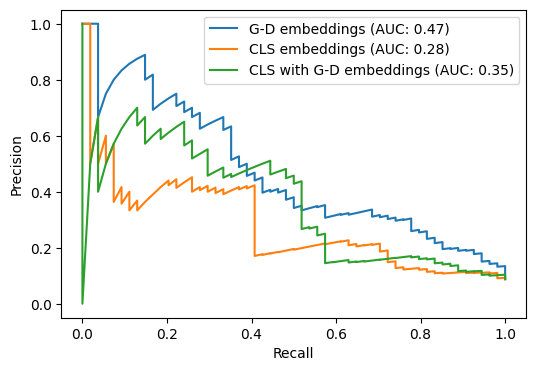

In [20]:
# Plotting PR Curves
plt.figure(figsize=(6, 4))
plt.plot(recall_svm_gd, precision_svm_gd, label='G-D embeddings (AUC: 0.47)')
plt.plot(recall_svm_cls, precision_svm_cls, label='CLS embeddings (AUC: 0.28)')
plt.plot(recall_svm_cls_with_gd, precision_svm_cls_with_gd, label='CLS with G-D embeddings (AUC: 0.35)')


plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.title('Precision-Recall curve For SVM classifier')
plt.legend()
plt.show()


In [8]:
import numpy as np
import wandb
from tqdm import tqdm
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

In [5]:
sweep_config = {
    'name': 'svm-hyperparameter-sweep',
    'method': 'random',  # or 'grid' or 'bayes'
    'metric': {
        'name': 'f1_weighted',
        'goal': 'maximize'   
    },
    'parameters': {
        'kernel': {
            'values': ['rbf', 'linear', 'poly']
        },
        'C': {
            'values': [0.1, 1, 10]
        },
        'degree': {
            'values': [4, 10, 30, 53, 70]
        },
        'gamma': {
            'values': ['scale', 'auto']
        }
    }
}


In [6]:
def train():
    # Initialize a new run
    run = wandb.init()

    # Get hyperparameters from this run's configuration
    config = wandb.config
    
    # Train SVM
    clf = SVC(kernel=config.kernel, C=config.C, degree=config.degree, 
              gamma=config.gamma, class_weight={0:1, 1:30}, probability=True)
    clf.fit(X_train_embeddings, y_train)

    # Evaluate
    y_pred = clf.predict(X_test_embeddings)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Log metrics to wandb
    wandb.log({"classification_report": report, "f1_avg": report['macro avg']['f1-score']})

    # Finish the run
    wandb.finish()


In [ ]:
sweep_id = wandb.sweep(sweep=sweep_config, project="val_data_svm_with_cls_and_gd")
wandb.agent(sweep_id, function=train)

In [5]:
import pandas as pd
# Load data from .tsv files
train_df = pd.read_csv('train_data', delimiter='\t')
test_df = pd.read_csv('val_data', delimiter='\t')

# Download the stopwords list
nltk.download('stopwords')

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(tokens)

# Apply the remove_stopwords function to the 'sentence' column
train_df['sentence'] = train_df['sentence'].apply(remove_stopwords)
test_df['sentence'] = test_df['sentence'].apply(remove_stopwords)

X_train = train_df['sentence'].tolist()
y_train = train_df['label'].tolist()

X_test = test_df['sentence'].tolist()
y_test = test_df['label'].tolist()

# Get BioBERT embeddings for the data
# try:
#     X_train_embeddings = np.vstack([get_specific_token_embeddings(sentence) for sentence in tqdm(X_train)])
#     X_test_embeddings = np.vstack([get_specific_token_embeddings(sentence) for sentence in tqdm(X_test)])
#     if(len(X_train_embeddings)==0):
#         print(sentence)
# except Exception as e:
#     print(e)
#     pass
    

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
sweep_config = {
    'name': 'xgboost-hyperparameter',
    'method': 'random',  # or 'grid' or 'bayes'
    'metric': {
        'name': 'f1_weighted',
        'goal': 'maximize'   
    },
    'parameters': {
        'learning_rate': {
            'values': [0.1, 0.01, 0.2,]
        },
        'max_depth': {
            'values': [5, 10, 20, 40]
        },
        'n_estimators': {
            'values': [100, 200, 400]
        },
        'scale_pos_weight': {
            'values': [100, 200, 500]
        },
        'gamma': {
            'values': [0.1, 0.2, 0.3]
        }
    }
}


In [ ]:
def train():
    # Initialize a new run
    run = wandb.init()

    # Get hyperparameters from this run's configuration
    config = wandb.config
    
    # Train XG BOOST
    clf = xgb.XGBClassifier(scale_pos_weight=config.scale_pos_weight, max_depth=config.max_depth, learning_rate=config.learning_rate, n_estimators=config.n_estimators, gamma=config.gamma)

    clf.fit(X_train_embeddings, y_train)
    

    # Evaluate
    y_pred = clf.predict(X_test_embeddings)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Log metrics to wandb
    wandb.log({"classification_report": report, "f1_avg": report['macro avg']['f1-score']})

    # Finish the run
    wandb.finish()


In [ ]:
sweep_id = wandb.sweep(sweep=sweep_config, project="xgboost_cls_with_ex_tokens")
wandb.agent(sweep_id, function=train)